In [1]:
# Copyright Contributors to the Pyro project.
# SPDX-License-Identifier: Apache-2.0

"""
 A toy mixture model to provide a simple example for implementing discrete enumeration.

 (A) -> [B] -> (C)

 A is an observed Bernoulli variable with Beta prior.
 B is a hidden variable which is a mixture of two Bernoulli distributions (with Beta priors),
 chosen by A being true or false.
 C is observed, and like B, is a mixture of two Bernoulli distributions (with Beta priors),
 chosen by B being true or false.
 There is a plate over the three variables for n independent observations of data.

 Because B is hidden and discrete we wish to marginalize it out of the model.
 This is done by:
    1) marking the model method with `@pyro.infer.config_enumerate`
    2) marking the B sample site in the model with `infer={"enumerate": "parallel"}`
    3) passing `pyro.infer.SVI` the `pyro.infer.TraceEnum_ELBO` loss function
"""

import argparse

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.distributions import constraints
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.beta import Beta
from tqdm import tqdm

import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.optim
from pyro.ops.indexing import Vindex

In [2]:
def main(args):
    num_obs = args.num_obs
    num_steps = args.num_steps
    prior, CPDs, data = generate_data(num_obs)
    posterior_params = train(prior, data, num_steps, num_obs)
    evaluate(CPDs, posterior_params)


def generate_data(num_obs):
    # domain = [False, True]
    prior = {
        "A": torch.tensor([1.0, 10.0]),
        "B": torch.tensor([[10.0, 1.0], [1.0, 10.0]]),
        "C": torch.tensor([[10.0, 1.0], [1.0, 10.0]]),
    }
    CPDs = {
        "p_A": Beta(prior["A"][0], prior["A"][1]).sample(),
        "p_B": Beta(prior["B"][:, 0], prior["B"][:, 1]).sample(),
        "p_C": Beta(prior["C"][:, 0], prior["C"][:, 1]).sample(),
    }
    data = {"A": Bernoulli(torch.ones(num_obs) * CPDs["p_A"]).sample()}
    data["B"] = Bernoulli(
        torch.gather(CPDs["p_B"], 0, data["A"].type(torch.long))
    ).sample()
    data["C"] = Bernoulli(
        torch.gather(CPDs["p_C"], 0, data["B"].type(torch.long))
    ).sample()
    return prior, CPDs, data


@pyro.infer.config_enumerate
def model(prior, obs, num_obs):
    p_A = pyro.sample("p_A", dist.Beta(1, 1))
    p_B = pyro.sample("p_B", dist.Beta(torch.ones(2), torch.ones(2)).to_event(1))
    p_C = pyro.sample("p_C", dist.Beta(torch.ones(2), torch.ones(2)).to_event(1))
    with pyro.plate("data_plate", num_obs):
        A = pyro.sample("A", dist.Bernoulli(p_A.expand(num_obs)), obs=obs["A"])
        # Vindex used to ensure proper indexing into the enumerated sample sites
        B = pyro.sample(
            "B",
            dist.Bernoulli(Vindex(p_B)[A.type(torch.long)]),
            infer={"enumerate": "parallel"},
        )
        pyro.sample("C", dist.Bernoulli(Vindex(p_C)[B.type(torch.long)]), obs=obs["C"])


def guide(prior, obs, num_obs):
    a = pyro.param("a", prior["A"], constraint=constraints.positive)
    pyro.sample("p_A", dist.Beta(a[0], a[1]))
    b = pyro.param("b", prior["B"], constraint=constraints.positive)
    pyro.sample("p_B", dist.Beta(b[:, 0], b[:, 1]).to_event(1))
    c = pyro.param("c", prior["C"], constraint=constraints.positive)
    pyro.sample("p_C", dist.Beta(c[:, 0], c[:, 1]).to_event(1))


def train(prior, data, num_steps, num_obs):
    pyro.clear_param_store()
    # max_plate_nesting = 1 because there is a single plate in the model
    loss_func = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1)
    svi = pyro.infer.SVI(model, guide, pyro.optim.Adam({"lr": 0.01}), loss=loss_func)
    losses = []
    for _ in tqdm(range(num_steps)):
        loss = svi.step(prior, data, num_obs)
        losses.append(loss)
    plt.figure()
    plt.plot(losses)
    plt.show()
    posterior_params = {k: np.array(v.data) for k, v in pyro.get_param_store().items()}
    posterior_params["a"] = posterior_params["a"][
        None, :
    ]  # reshape to same as other variables
    return posterior_params


def evaluate(CPDs, posterior_params):
    true_p_A, pred_p_A = get_true_pred_CPDs(CPDs["p_A"], posterior_params["a"])
    true_p_B, pred_p_B = get_true_pred_CPDs(CPDs["p_B"], posterior_params["b"])
    true_p_C, pred_p_C = get_true_pred_CPDs(CPDs["p_C"], posterior_params["c"])
    print("\np_A = True")
    print("actual:   ", true_p_A)
    print("predicted:", pred_p_A)
    print("\np_B = True | A = False/True")
    print("actual:   ", true_p_B)
    print("predicted:", pred_p_B)
    print("\np_C = True | B = False/True")
    print("actual:   ", true_p_C)
    print("predicted:", pred_p_C)


def get_true_pred_CPDs(CPD, posterior_param):
    true_p = CPD.numpy()
    pred_p = posterior_param[:, 0] / np.sum(posterior_param, axis=1)
    return true_p, pred_p

100%|██████████| 4000/4000 [00:57<00:00, 69.20it/s]


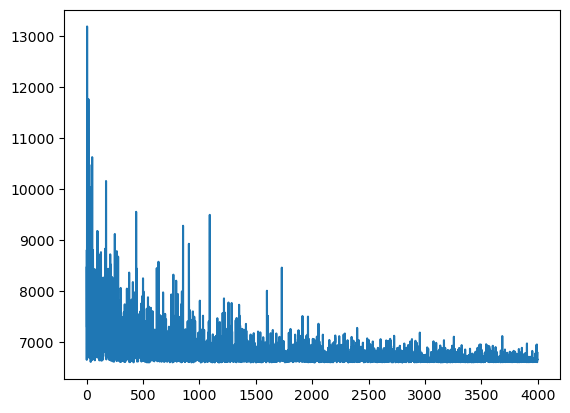


p_A = True
actual:    0.014530175
predicted: [0.01427063]

p_B = True | A = False/True
actual:    [0.7700205  0.21925935]
predicted: [0.8757907 0.0986331]

p_C = True | B = False/True
actual:    [0.8388428  0.11006102]
predicted: [0.6197228  0.20252986]


In [3]:
if __name__ == "__main__":
    assert pyro.__version__.startswith("1.8.6")
    parser = argparse.ArgumentParser(description="Toy mixture model")
    parser.add_argument("-n", "--num-steps", default=4000, type=int)
    parser.add_argument("-o", "--num-obs", default=10000, type=int)
    args = parser.parse_args(args=[])
    main(args)